In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

[WinError 3] The system cannot find the path specified: 'Downloads/TSIS_V10_pickles/'
C:\Users\cae2\Documents\Heat Map


In [4]:
data_dict = pd.read_pickle(r"C:\Users\cae2\Downloads\TSIS_V10_pickles\V10_prod_all_scans_dict_83_84_85_86_87_88_89_90_91_92_93_94_MD_81_to_2000.pickle")
print(f"Imported files with keys {data_dict.keys()}")

Imported files with keys dict_keys([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])


In [5]:
df = data_dict[83]
ds = xr.Dataset.from_dataframe(df, sparse=True)

In [6]:
# create the flat array
detectors = ds.detector.to_numpy().ravel()
# iterate through the array and only keep string data
detectors = [detector for detector in detectors if type(detector) is str]
# convert to a set to get unique values
list(set(detectors))

['ESR']

In [7]:
# create the flat array
channels = ds.channel.to_numpy().ravel()
# iterate through the array and only keep string data
channels = [channel for channel in channels if type(channel) is str]
# convert to a set to get unique values
list(set(channels))

['A']

In [8]:
def unique_string_from_sparse_dataarray(da):
    xs = da.to_numpy().ravel()
    xs = [x for x in xs if type(x) is str]
    xs = list(set(xs))
    if len(xs) == 1:
        return xs[0]
    else:
        return xs

In [9]:
unique_string_from_sparse_dataarray(ds.channel)

'A'

In [10]:
dataset_dict = {
    key: xr.Dataset.from_dataframe(df, sparse=True) for key, df in data_dict.items()
}  # exactly is just data_dict

In [11]:
keys = list(
    dataset_dict.keys()
)  # list because error, and maybe this disconnects data from dictionary
for key in keys:
    ds = dataset_dict.pop(key)
    new_key = unique_string_from_sparse_dataarray(
        ds.channel
    ), unique_string_from_sparse_dataarray(ds.detector)
    dataset_dict[new_key] = ds


In [12]:
dataset_dict.keys()

dict_keys([('A', 'ESR'), ('A', 'IR'), ('A', 'VIS'), ('A', 'UV'), ('B', 'ESR'), ('B', 'IR'), ('B', 'VIS'), ('B', 'UV'), ('C', 'ESR'), ('C', 'IR'), ('C', 'VIS'), ('C', 'UV')])

In [13]:
da = ds.sirr[:, 400]  # get the time series of the ESR at the 400th wavelength
da = da.as_numpy()  # convert to numpy array so not sparse now
da = da.dropna(dim="scan_time")  # drop elements with no value
da.interp(scan_time=750)  # interpolate the value to the scan time 750

# note this all could have been a single line just appending the methods at the end

<xarray.DataArray 'sirr' ()>
array(0.05610531)
Coordinates:
    wavelength  float64 223.2
    scan_time   int32 750

In [14]:
ds_vis_a = dataset_dict["B", "VIS"]
ds_esr_a = dataset_dict["B", "ESR"]

Text(0, 0.5, 'wavelength exists in\nESR data')

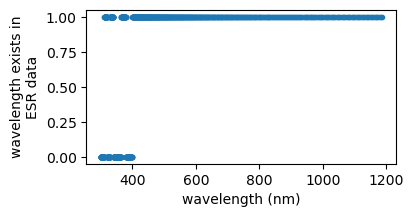

In [15]:
good_wl = [wl in ds_esr_a.wavelength.values for wl in ds_vis_a.wavelength.values]
fig, ax = plt.subplots(1)
ax.plot(ds_vis_a.wavelength.values, good_wl, ".")
fig.set_size_inches([4, 2])
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("wavelength exists in\nESR data")

In [16]:
ds_combined = xr.combine_by_coords(
    [ds_vis_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
ds_combined.as_numpy()

<xarray.Dataset>
Dimensions:              (scan_time: 2222, wavelength: 1183)
Coordinates:
  * scan_time            (scan_time) float64 81.31 81.51 ... 1.998e+03 1.998e+03
  * wavelength           (wavelength) float64 241.9 242.1 ... 2.399e+03
Data variables:
    pt_time              (scan_time, wavelength) float64 nan nan nan ... nan nan
    sirr                 (scan_time, wavelength) float64 nan nan nan ... nan nan
    imode                (scan_time, wavelength) float64 nan nan nan ... nan nan
    detector             (scan_time, wavelength) object nan nan nan ... nan nan
    channel              (scan_time, wavelength) object nan nan nan ... nan nan
    solar_exposure_days  (scan_time, wavelength) float64 nan nan nan ... nan nan
    activity_name        (scan_time, wavelength) object nan nan nan ... nan nan
    sirr_esr             (scan_time, wavelength) float64 nan nan nan ... nan nan

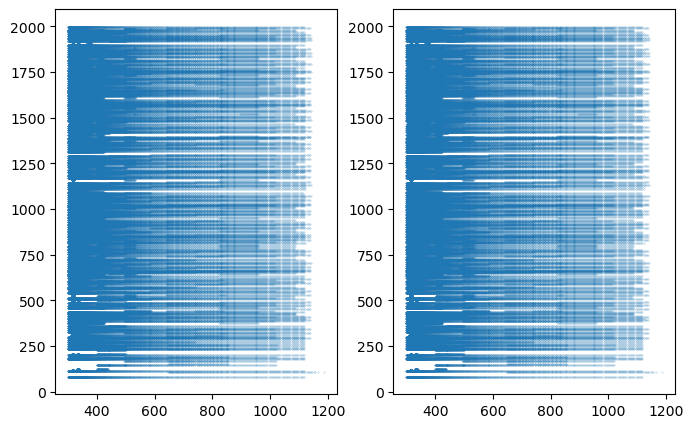

In [17]:
fig,ax = plt.subplots(1,2)
x,y = np.where(ds_vis_a.sirr.to_numpy()>0)
ax[0].plot(ds_vis_a.wavelength.to_numpy()[y],ds_vis_a.scan_time.to_numpy()[x],'.',markersize=.25)
x,y = np.where(ds_combined.sirr.to_numpy()>0)
ax[1].plot(ds_combined.wavelength.to_numpy()[y],ds_combined.scan_time.to_numpy()[x],'.',markersize=.25)
fig.set_size_inches([8,5])

In [18]:
ds_combined["sirr_esr_interp"] = ds_combined.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)

In [19]:
da_ratio = (ds_combined.sirr / ds_combined.sirr_esr_interp)

In [20]:
scan_time = ds_combined.scan_time.to_numpy()

In [23]:
da_ratio_interp_vis = da_ratio.interpolate_na(
    dim="scan_time", method="linear"
)

wavelengths_vis = da_ratio_interp_vis.wavelength.to_numpy()

da_ratio_interp_norm_vis = da_ratio_interp_vis.copy()

for n in range(len(wavelengths_vis)):
    col_uv = da_ratio_interp_norm_vis[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_uv) > 0:
        first_val = col_uv[0] #finds all first values in row of ratio of sirr
        da_ratio_interp_norm_vis[:,n] = da_ratio_interp_norm_vis[:,n] / first_val #divides row by first value that isnt nan

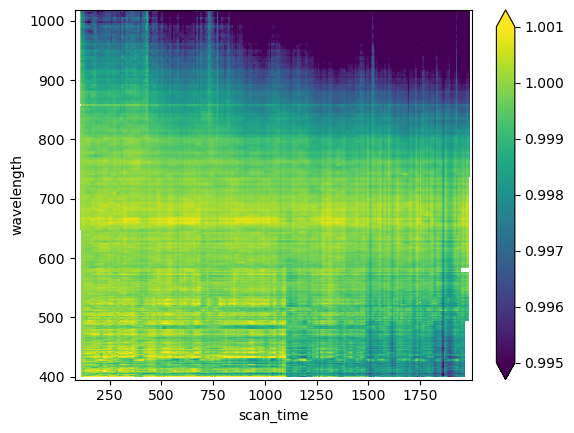

In [27]:
da_ratio_interp_norm_vis.sel(wavelength = slice(395, 1020)).plot(x = "scan_time",  vmin = .995, vmax = 1.001)

In [6]:
da_ratio_interp.sel(wavelength = slice(500, 900)).plot(x = "scan_time", robust = True)

NameError: name 'da_ratio_interp' is not defined

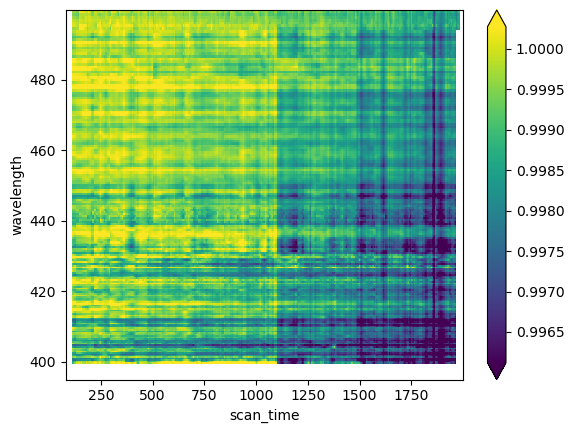

In [32]:
da_ratio_interp.sel(wavelength = slice(395, 500)).plot(x = "scan_time", robust = True)

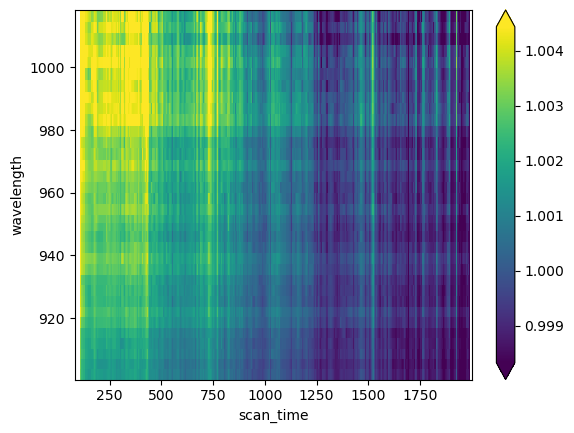

In [33]:
da_ratio_interp.sel(wavelength = slice(900, 1020)).plot(x = "scan_time", robust = True)